<a href="https://colab.research.google.com/github/Jsgithubchannel/AIFFEL_quest_cr/blob/main/MainQuest/Quest03/MainQuest3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 폐렴아 기다려라!

- 개요
의료 인공지능은 다양한 분야에서 사용됩니다. 질병의 정확한 분류 또는 환자의 중증도를 확인하는 용도 등 다양한 용도로 사용됩니다. 이제 우리는 의사처럼 질병을 찾아내는 딥러닝 모델을 만들어보려고 합니다.

우리가 할 것은 폐렴(Pneumonia)을 찾아내는 딥러닝 모델을 만드는 것입니다.

- 캐글의 Chest X-Ray Images
3개의 폴더 (train, test, val)로 구성되며, 각 이미지 카테고리 (폐렴 / 정상)에 대한 하위 폴더를 포함합니다. 5,856 개의 X-Ray 이미지 (JPEG)와 2 개의 범주 (폐렴 / 정상)가 있습니다. 전체 데이터의 크기는 총 1.2GB 가량 됩니다.

- 폐렴의 구별법은 언뜻 예상외로 간단합니다.
X-RAY 사진상, 다양한 양상의 음영(폐 부위에 희미한 그림자) 증가가 관찰됩니다.

## Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')

100%|██████████| 2.29G/2.29G [00:21<00:00, 115MB/s]


Extracting files...
Data source import complete.


In [3]:
print(f"Dataset root path: {paultimothymooney_chest_xray_pneumonia_path}")
print(f"Root path exists: {tf.io.gfile.exists(paultimothymooney_chest_xray_pneumonia_path)}")

Dataset root path: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
Root path exists: True


In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = paultimothymooney_chest_xray_pneumonia_path
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'
BATCH_SIZE = 8
EPOCHS = 10

print(ROOT_PATH)

/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


## 데이터 가져오기

In [6]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [7]:
# filenames에 train과 validation 데이터 모두 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# filenames를 8:2로 분할
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


### 정상 이미지, 폐렴 이미지 구분하기 -> 파일 경로에 힌트 있음

In [8]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-0578-0001.jpeg
Pneumonia image path
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person537_bacteria_2261.jpeg


In [9]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

print(f"Normal images count in training set: {COUNT_NORMAL}")
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


### Train 데이터셋, validation 데이터셋 개수 확인

In [10]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

print(f"Training images count: {TRAIN_IMG_COUNT}")
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 함수 생성

In [11]:
# 파일 경로의 끝에서 두번째 부분 확인 -> 양성, 음성 구분
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return tf.cast(parts[-2] == "PNEUMONIA", tf.int32)   # 폐렴이면 양성(True), 노말이면 음성(False)
    # Value passed to parameter 'x' has DataType bool not in list of allowed values 에러 해결

# 이미지를 알맞은 형식으로 바꿈
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img

# 이미지 파일 경로 입력 -> 이미지와 라벨 읽어옴
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

### train 데이터 셋과 validation 데이터 셋 생성

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1): # train_ds.take(1)은 하나의 데이터만 가져온다는 뜻
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


### test 데이터셋 생성

In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
  ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE) # BATCH_SIZE에서 정한 만큼의 배치
  ds = ds.prefetch(buffer_size=AUTOTUNE) # 학습 데이터를 나눠서 읽어옴, 첫 번째 데이터 GPU에서 학습하는 동안, 두 번째 데이터 CPU에서 준비 -> 리소스 유휴 상태 줄임
  return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 데이터 시각화

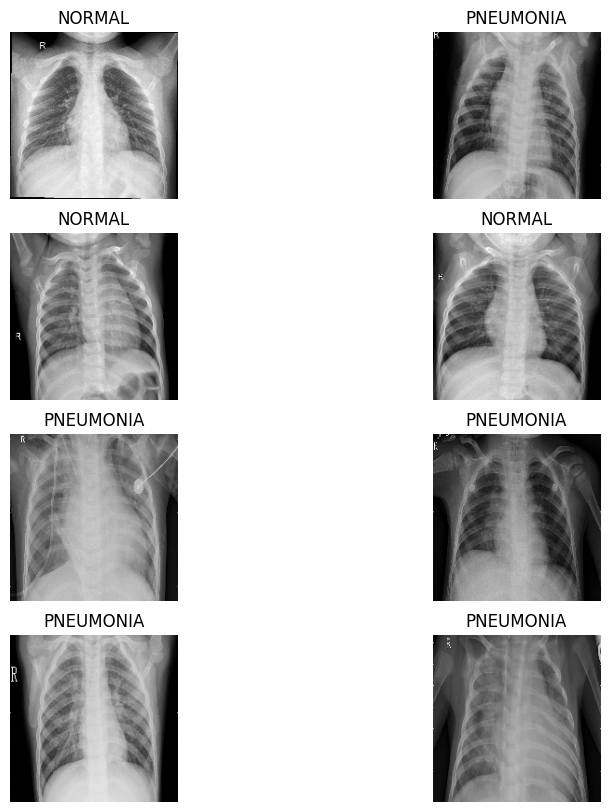

In [16]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10, 10))
  for n in range(BATCH_SIZE):
    ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)
    plt.imshow(image_batch[n])
    if label_batch[n]:
      plt.title("PNEUMONIA")
    else:
      plt.title("NORMAL")
    plt.axis("off")

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 루브릭) CNN 모델링
* ✅ 의료영상을 처리하는 CNN 기반 베이스 모델 구현 - 1점

In [17]:
# Convolution block
# Convolution 두 번 진행 -> Batch Normalization 통해서 Gradient vanishing, gradient exploding 해결 -> Max Pooling
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

# Dense Block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [19]:
def save_model(model, model_name="pneumonia_model"):
    """
    Save the trained model to disk with proper extension

    Parameters:
    model: trained tensorflow model
    model_name: name for the saved model (default: "pneumonia_model")
    """
    # Create models directory if it doesn't exist
    if not os.path.exists('models'):
        os.makedirs('models')

    # Ensure the model name has .keras extension
    if not model_name.endswith('.keras'):
        model_name = f"{model_name}.keras"

    # Save the model
    model_path = os.path.join('models', model_name)
    model.save(model_path)
    print(f"Model saved to {model_path}")

In [20]:
def load_or_create_model(model_name="pneumonia_model"):
    """
    Load a trained model from disk or create a new one if it doesn't exist

    Parameters:
    model_name: name of the saved model (default: "pneumonia_model")

    Returns:
    loaded or newly created tensorflow model
    """
    if not model_name.endswith('.keras'):
        model_name = f"{model_name}.keras"

    model_path = os.path.join('models', model_name)

    if os.path.exists(model_path):
        print(f"Loading existing model from {model_path}")
        return tf.keras.models.load_model(model_path)
    else:
        print("No existing model found. Creating new model...")
        model = build_model()

        # Compile the model
        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=METRICS
        )

        return model

## 데이터 imbalance 처리

In [21]:
# Weight balancing 테크닉 사용
# Weight balancing: training set의 각 데이터에서 loss 계산시, 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치 부여

# weight_for_0 : Normal 이미지에 사용할 weight, weight_for_1 : Pneumonia 이미지에 사용할 weight
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 모델 훈련

In [23]:
baseline_model = load_or_create_model()

if not os.path.exists(os.path.join('models', 'baseline_model.keras')):
    history = baseline_model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    save_model(baseline_model)

No existing model found. Creating new model...
Epoch 1/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 96s 133ms/step - accuracy: 0.6994 - loss: 0.6106 - precision: 0.9026 - recall: 0.6636 - val_accuracy: 0.7346 - val_loss: 1.2100 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 81s 155ms/step - accuracy: 0.8565 - loss: 0.3340 - precision: 0.9561 - recall: 0.8442 - val_accuracy: 0.6452 - val_loss: 0.9638 - val_precision: 1.0000 - val_recall: 0.5176
Epoch 3/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 81s 155ms/step - accuracy: 0.8318 - loss: 0.3813 - precision: 0.9504 - recall: 0.8142 - val_accuracy: 0.7904 - val_loss: 0.3257 - val_precision: 0.7788 - val_recall: 0.9987
Epoch 4/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 82s 157ms/step - accuracy: 0.8483 - loss: 0.3191 - precision: 0.9705 - recall: 0.8231 - val_accuracy: 0.9337 - val_loss: 0.2270 - val_precision: 0.9874 - val_recall: 0.9217
Epoch 5/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 70s 134ms/step - accuracy: 0.8619 - loss: 0.3281 - precision:

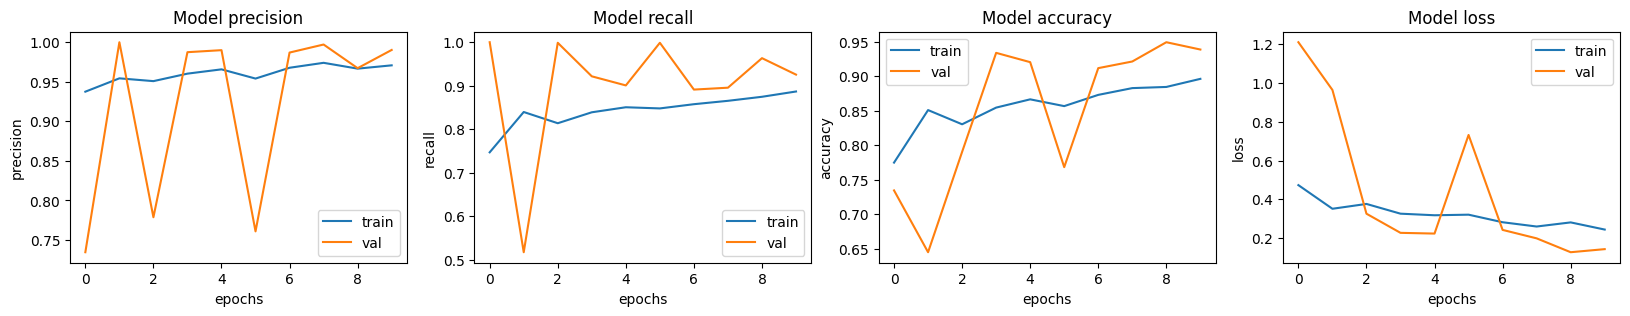

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## 테스트 데이터로 모델 평가

In [25]:
loss, accuracy, precision, recall = baseline_model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.7966 - loss: 0.4706 - precision: 0.7635 - recall: 0.9339
Loss: 0.49106520414352417,
Accuracy: 0.8157051205635071,
Precision: 0.7931769490242004,
Recall: 0.9538461565971375


# 폐렴 진단기 성능개선 - Augmentation

## Augmentation 기법 도입

In [26]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image,label

def prepare_for_training_augment(ds, shuffle_buffer_size=1000):
    # augment 적용 부분
    ds = ds.map(
            augment,
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

# 헷갈렸던 부분 -> 복습하기 계속 (16, 16, 180, 180, 3)로 나왔음 (정답은 16, 180, 180, 3). 즉, batching is happening twice, causing an extra dimension
train_ds = train_list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_augment_ds = prepare_for_training_augment(train_ds)
val_augment_ds = prepare_for_training_augment(val_list_ds.map(process_path).batch(BATCH_SIZE))

## Augmentation 기법 모델 학습

In [27]:
augment_model = load_or_create_model()

if not os.path.exists(os.path.join('models', 'augment_model.keras')):
    augment_history = augment_model.fit(
        train_augment_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_augment_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    save_model(augment_model)

Loading existing model from models/pneumonia_model.keras
Epoch 1/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 93s 57ms/step - accuracy: 0.9076 - loss: 0.2166 - precision: 0.9801 - recall: 0.8929 - val_accuracy: 0.8576 - val_loss: 0.3050 - val_precision: 0.9984 - val_recall: 0.8076
Epoch 2/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 1.0000 - loss: 0.0889 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.8556 - val_loss: 0.3113 - val_precision: 0.9984 - val_recall: 0.8045
Epoch 3/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 95s 35ms/step - accuracy: 0.9082 - loss: 0.2257 - precision: 0.9761 - recall: 0.8981 - val_accuracy: 0.9086 - val_loss: 0.2132 - val_precision: 0.9841 - val_recall: 0.8902
Epoch 4/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8750 - loss: 0.2238 - precision: 0.8571 - recall: 1.0000 - val_accuracy: 0.9066 - val_loss: 0.2190 - val_precision: 0.9812 - val_recall: 0.8901
Epoch 5/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.9159 - loss: 0.2042 - preci

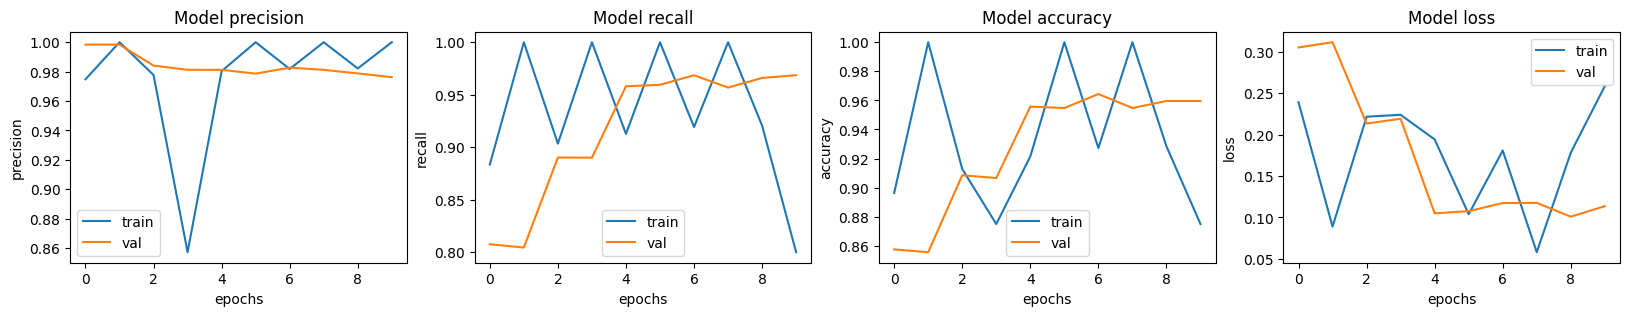

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(augment_history.history[met])
    ax[i].plot(augment_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## 테스트 데이터로 모델 평가

In [29]:
loss, accuracy, precision, recall = augment_model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.7481 - loss: 2.1251 - precision: 0.7097 - recall: 0.9752 
Loss: 1.0354456901550293,
Accuracy: 0.7916666865348816,
Precision: 0.7610442042350769,
Recall: 0.971794843673706


# 루브릭) Augmentation 성능 비교 시각화
* ✅ 데이터 augmentation 기법을 사용해서 베이스 모델과의 성능을 비교 - 1점

In [31]:
def plot_comparison(model_histories, metric_names=['accuracy', 'precision', 'recall', 'loss']):
    """
    Plot comparison of multiple models' training histories

    Parameters:
    model_histories: dict of format {'model_name': history_object, ...}
    metric_names: list of metrics to plot (default: ['accuracy', 'precision', 'recall', 'loss'])
    """
    fig, axes = plt.subplots(1, len(metric_names), figsize=(20, 4))
    axes = axes.ravel()

    # Define a color map for different models
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f', '#9b59b6', '#1abc9c']

    for i, metric in enumerate(metric_names):
        ax = axes[i]

        # Plot each model's metrics
        for (model_name, history), color in zip(model_histories.items(), colors):
            # Training metrics
            ax.plot(history.history[metric],
                   color=color,
                   label=f'{model_name} (train)',
                   linestyle='-')

            # Validation metrics
            if f'val_{metric}' in history.history:
                ax.plot(history.history[f'val_{metric}'],
                       color=color,
                       label=f'{model_name} (val)',
                       linestyle='--')

        ax.set_title(f'Model {metric.capitalize()}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    return fig

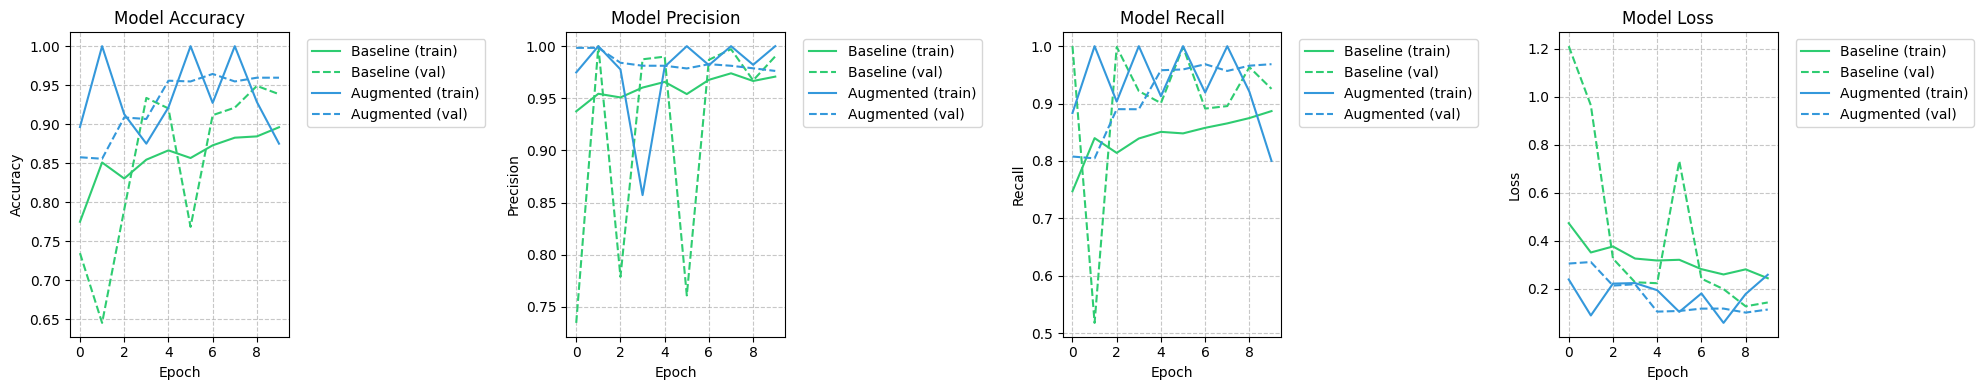

In [32]:

model_histories = {
    'Baseline': history,  # From baseline model
    'Augmented': augment_history  # From augmented model
}

# Plot comparison
fig = plot_comparison(model_histories)
plt.show()

# 루브릭) 모델 구조 변경을 통해 베이스 모델과의 성능 비교
- ✅ 모델 구조 변경을 통해 베이스 모델과의 성능 비교 - 1점

In [33]:
def build_model_v2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(32, 5, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, 5, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.3),

        conv_block(256),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),
        dense_block(256, 0.5),
        tf.keras.layers.BatchNormalization(),
        dense_block(128, 0.4),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model

In [34]:
v2_model = build_model_v2()

v2_history = v2_model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 94s 142ms/step - accuracy: 0.7105 - loss: 0.5541 - precision: 0.9010 - recall: 0.6843 - val_accuracy: 0.7375 - val_loss: 0.5154 - val_precision: 0.7372 - val_recall: 1.0000
Epoch 2/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 1.0000 - loss: 0.1879 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.7365 - val_loss: 0.5090 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 3/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 83s 158ms/step - accuracy: 0.8599 - loss: 0.3287 - precision: 0.9532 - recall: 0.8532 - val_accuracy: 0.7356 - val_loss: 3.1969 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 4/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 1.0000 - loss: 0.1231 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.7356 - val_loss: 3.2456 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 5/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 142s 235ms/step - accuracy: 0.8958 - loss: 0.2723 - precision: 0.9673 - recall: 0.8900 - val_accuracy: 0.7962 

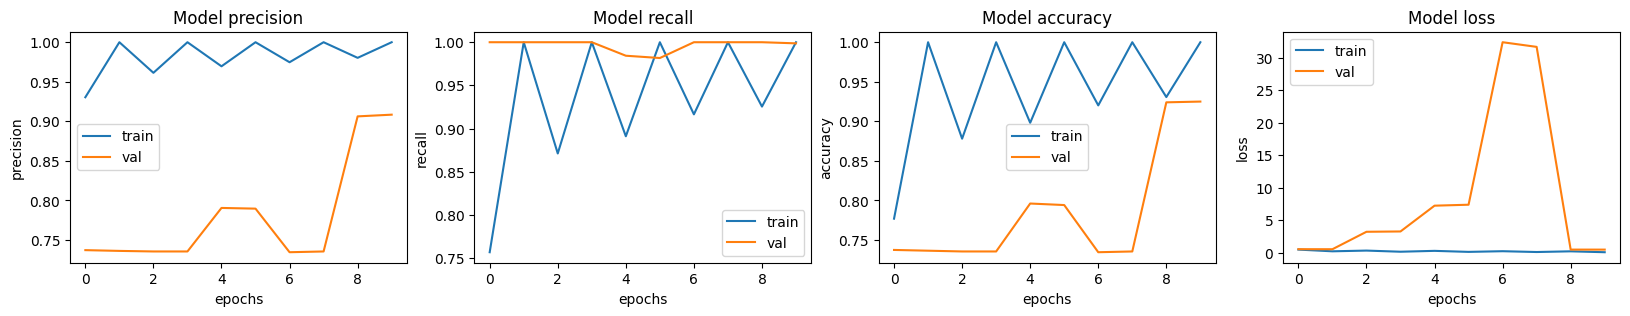

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(v2_history.history[met])
    ax[i].plot(v2_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## 테스트 데이터로 모델 평가

In [40]:
loss, accuracy, precision, recall = v2_model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.6748 - loss: 2.6073 - precision: 0.6520 - recall: 1.0000
Loss: 1.7070220708847046,
Accuracy: 0.7051281929016113,
Precision: 0.6794425249099731,
Recall: 1.0


## 베이스 모델 VS 구조 변경 모델

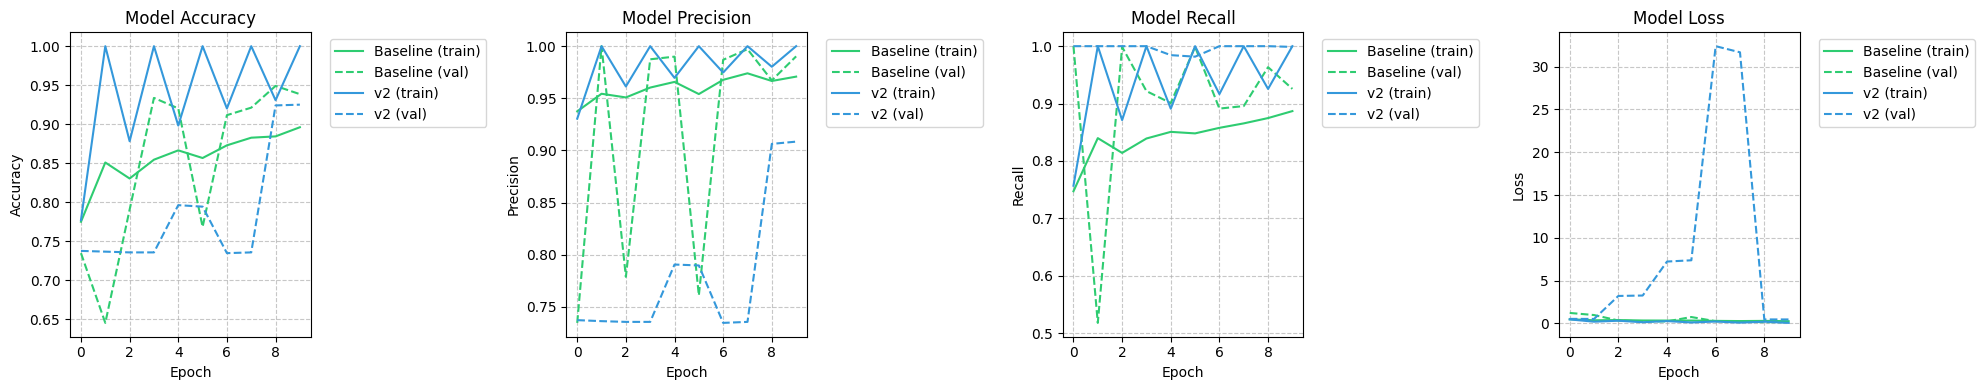

In [37]:
model_histories = {
    'Baseline': history,
    'V2': v2_history
}

fig = plot_comparison(model_histories)
plt.show()

# 루브릭) ResNet-18 모델을 구현
- ✅ ResNet-18 모델을 구현하고 학습 성공 - 1점

In [42]:
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False):
    shortcut = x


    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)


    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)


    if conv_shortcut:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)


    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)

    return x

def build_resnet18():
    """
    Build ResNet-18 model with correct output shape for binary classification
    """
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # conv1: 7x7, 64, stride 2
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # 3x3 max pool, stride 2
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # conv2_x: [3x3, 64] × 2
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    # conv3_x: [3x3, 128] × 2
    x = residual_block(x, 128, stride=2, conv_shortcut=True)
    x = residual_block(x, 128)

    # conv4_x: [3x3, 256] × 2
    x = residual_block(x, 256, stride=2, conv_shortcut=True)
    x = residual_block(x, 256)

    # conv5_x: [3x3, 512] × 2
    x = residual_block(x, 512, stride=2, conv_shortcut=True)
    x = residual_block(x, 512)

    # 7x7 average pool
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Dense layers
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs, name='resnet18_fixed')

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

    return model


# Create and train ResNet model
resnet_model = build_resnet18()

In [43]:
if not os.path.exists(os.path.join('models', 'resnet_model.keras')):
    resnet_history = resnet_model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )
    save_model(resnet_model, "resnet_model")


Epoch 1/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 97s 134ms/step - accuracy: 0.7938 - loss: 0.5070 - precision: 0.9353 - recall: 0.7740 - val_accuracy: 0.2769 - val_loss: 5.1400 - val_precision: 1.0000 - val_recall: 0.0157
Epoch 2/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 1.0000 - loss: 0.1158 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.2750 - val_loss: 5.0957 - val_precision: 1.0000 - val_recall: 0.0144
Epoch 3/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 64s 123ms/step - accuracy: 0.8825 - loss: 0.2976 - precision: 0.9603 - recall: 0.8781 - val_accuracy: 0.2740 - val_loss: 10.7075 - val_precision: 1.0000 - val_recall: 0.0131
Epoch 4/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 1.0000 - loss: 0.0795 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.2731 - val_loss: 9.9371 - val_precision: 1.0000 - val_recall: 0.0143
Epoch 5/10
523/523 ━━━━━━━━━━━━━━━━━━━━ 143s 201ms/step - accuracy: 0.9077 - loss: 0.2366 - precision: 0.9717 - recall: 0.9019 - val_accuracy: 0.7356

## 테스트 데이터로 모델 평가

In [45]:
loss, accuracy, precision, recall = resnet_model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.6272 - loss: 2.3747 - precision: 0.6270 - recall: 1.0000
Loss: 2.3886516094207764,
Accuracy: 0.6266025900840759,
Precision: 0.6260032057762146,
Recall: 1.0


## 베이스 모델 VS Resnet 모델

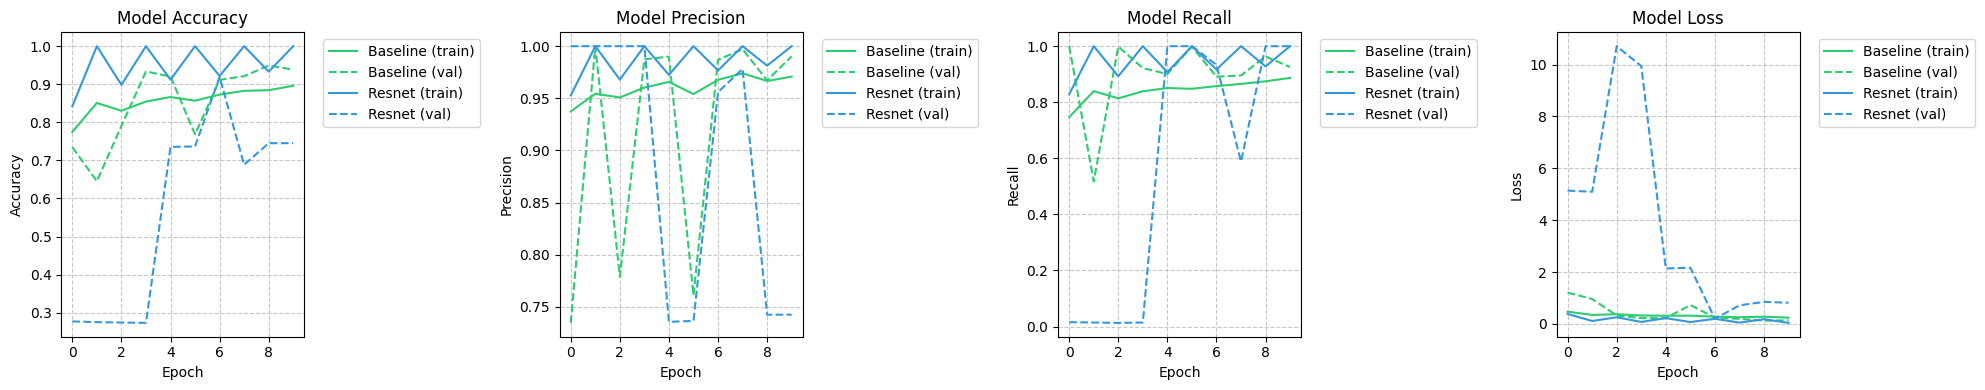

In [44]:
model_histories = {
    'Baseline': history,
    'Resnet': resnet_history
}

fig = plot_comparison(model_histories)
plt.show()

# 회고
환경설정이 이렇게 어려운 건 처음이었다. 코드 작성보다 환경 설정에서 약 5시간 넘게 소비한 것 같다. 그리고 print문에서 무한루프에 갇혔었다 -> batch()가 두번 적용되어서 그랬다.



## 왜 prepare_for_training_augment() 에서 (16, 16, 180, 180, 3)가 나왔을까?

### 문제 발생 원인: batch()가 두 번 적용됨
batching이 중복 적용되어, 16개의 미니배치가 또다시 16개로 묶이는 문제가 발생

```
train_ds = train_list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # ⬅️ ✅ 첫 번째 배칭

train_augment_ds = prepare_for_training_augment(train_ds)  # ⬅️ ⚠️ 여기서 또 배칭됨 (중복!)
```

### 해결 방법: prepare_for_training_augment()에서 batch() 제거
 ```
def prepare_for_training_augment(ds, shuffle_buffer_size=1000):
    ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)  # ✅ 배치 전에 augmentation
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)  # ✅ 배치하지 않음 (이미 배치됨)
    return ds
```

# Reference
중간에 계속 훈련이 끊겨 학습이 중단되는걸 보고 모델을 저장하고 불러오는 방법을 찾았다.

https://kylo8.tistory.com/entry/%EB%94%A5%EB%9F%AC%EB%8B%9D-%ED%95%99%EC%8A%B5-%EB%AA%A8%EB%8D%B8-%EC%A0%80%EC%9E%A5%ED%95%98%EA%B8%B0-%EB%B6%88%EB%9F%AC%EC%98%A4%EA%B8%B0-%EB%B3%B4%EA%B8%B0